In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set paths
source_dir = 'augmented_data_balanced_clean'
output_dir = 'split_data'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Create output folders
for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Process each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_images, val_images = train_test_split(images, test_size=0.1, random_state=42)

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy2(src, dst)

    # Move validation images
    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy2(src, dst)

print("Dataset split into 90% train and 10% val successfully.")


Dataset split into 90% train and 10% val successfully.


In [2]:
import os

def count_images_per_class(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            class_counts[class_name] = num_images
    return class_counts

# Set train and val directories
train_dir = 'split_data/train'
val_dir = 'split_data/val'

# Get counts
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

# Display results
print("Training Set Counts:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")

print("\nValidation Set Counts:")
for cls, count in val_counts.items():
    print(f"{cls}: {count}")


Training Set Counts:
CNV: 37373
DME: 37373
DRUSEN: 37373
NORMAL: 37373
NOT_AN_OCT_IMAGE: 37373

Validation Set Counts:
CNV: 4153
DME: 4153
DRUSEN: 4153
NORMAL: 4153
NOT_AN_OCT_IMAGE: 4153


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32

In [5]:
# Paths (change these if your dataset is in another location)
train_dir = 'split_data/train'  # 👈 Replace with your actual train path
val_dir = 'split_data/val'      # 👈 Replace with your actual val path


In [6]:
# ✅ Data Augmentation + Normalization for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)


In [7]:
# ✅ Normalization for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [8]:
# ✅ One-hot encoded data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 186865 images belonging to 5 classes.


In [9]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 20765 images belonging to 5 classes.


In [10]:
# ✅ Base model (EfficientNetB0)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)
base_model.trainable = False  # Freeze base for initial transfer learning


In [11]:
# ✅ Custom CNN head
x = base_model.output
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)


In [12]:

# ✅ Final model
model = Model(inputs=base_model.input, outputs=output)


In [13]:
# ✅ Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
# ✅ Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
5840/5840 [==============================] - 2481s 423ms/step - loss: 0.3793 - accuracy: 0.8572 - val_loss: 0.2550 - val_accuracy: 0.9030
Epoch 2/20
5840/5840 [==============================] - 661s 113ms/step - loss: 0.2981 - accuracy: 0.8864 - val_loss: 0.2386 - val_accuracy: 0.9087
Epoch 3/20
5840/5840 [==============================] - 570s 98ms/step - loss: 0.2714 - accuracy: 0.8969 - val_loss: 0.2338 - val_accuracy: 0.9095
Epoch 4/20
5840/5840 [==============================] - 568s 97ms/step - loss: 0.2548 - accuracy: 0.9034 - val_loss: 0.2113 - val_accuracy: 0.9189
Epoch 5/20
5840/5840 [==============================] - 565s 97ms/step - loss: 0.2427 - accuracy: 0.9083 - val_loss: 0.2123 - val_accuracy: 0.9168
Epoch 6/20
5840/5840 [==============================] - 558s 96ms/step - loss: 0.2316 - accuracy: 0.9129 - val_loss: 0.2032 - val_accuracy: 0.9220
Epoch 7/20
5840/5840 [==============================] - 565s 97ms/step - loss: 0.2238 - accuracy: 0.9151 - val_loss

KeyboardInterrupt: 

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
# ✅ Ensure validation generator doesn't shuffle (to match order)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 23765 images belonging to 5 classes.


In [29]:
# ✅ Predict on validation set
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# ✅ Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


743/743 [==============================] - 56s 74ms/step
Classification Report:
                  precision    recall  f1-score   support

             CNV       0.95      0.91      0.93      4753
             DME       0.92      0.89      0.91      4753
          DRUSEN       0.85      0.89      0.87      4753
          NORMAL       0.95      0.99      0.97      4753
NOT_AN_OCT_IMAGE       1.00      1.00      1.00      4753

        accuracy                           0.94     23765
       macro avg       0.94      0.94      0.94     23765
    weighted avg       0.94      0.94      0.94     23765



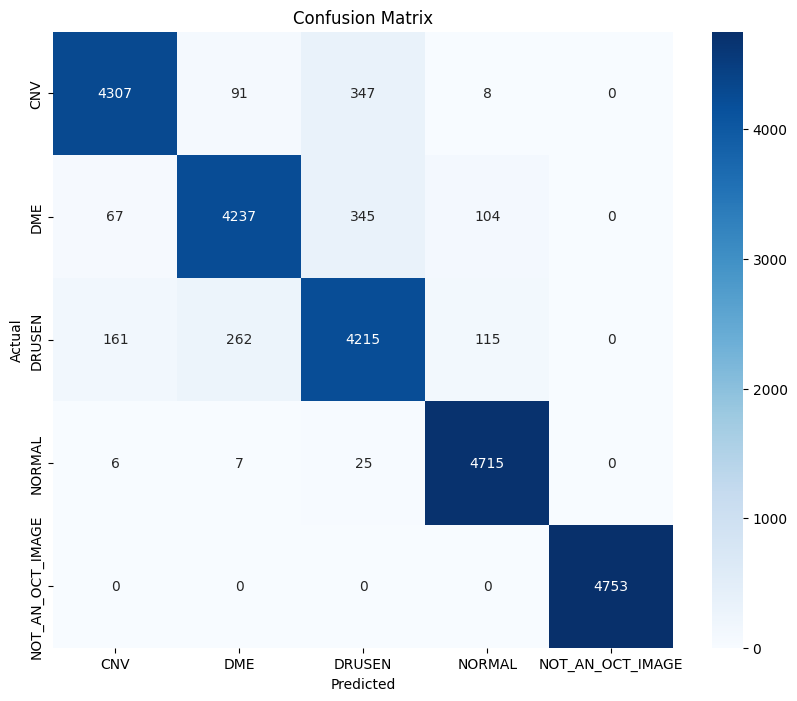

In [30]:
# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to the test image
img_path = "Screenshot 2025-05-22 042223.png"  # 👈 Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)        # Normalize


In [63]:
# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])


1/1 [==============================] - 0s 23ms/step


In [64]:
# Get class label mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f})")


Predicted class: DRUSEN (Confidence: 0.96)


In [65]:
print("Scanning inside model layers...")

for layer in model.layers:
    for attr_name in dir(layer):
        if attr_name.startswith("_"):
            continue
        try:
            attr_value = getattr(layer, attr_name)
        except Exception:
            continue  # Skip attributes that throw errors

        if isinstance(attr_value, tf.Tensor):
            print(f"⚡ Found Tensor in layer '{layer.name}' attribute: '{attr_name}'")
        elif isinstance(attr_value, (list, tuple)):
            for item in attr_value:
                if isinstance(item, tf.Tensor):
                    print(f"⚡ Found Tensor inside list/tuple in layer '{layer.name}' attribute: '{attr_name}'")
        elif isinstance(attr_value, dict):
            for key, item in attr_value.items():
                if isinstance(item, tf.Tensor):
                    print(f"⚡ Found Tensor inside dict in layer '{layer.name}' at key '{key}'")


Scanning inside model layers...
⚡ Found Tensor in layer 'normalization_1' attribute: 'mean'
⚡ Found Tensor in layer 'normalization_1' attribute: 'variance'
⚡ Found Tensor in layer 'rescaling_3' attribute: 'scale'


C:\Users\DELL\AppData\Local\Temp\ipykernel_15528\4088505527.py:8: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  attr_value = getattr(layer, attr_name)


In [66]:
model.get_layer('normalization_1').mean = model.get_layer('normalization_1').mean.numpy()
model.get_layer('normalization_1').variance = model.get_layer('normalization_1').variance.numpy()
model.get_layer('rescaling_3').scale = model.get_layer('rescaling_3').scale.numpy()


In [68]:
model.save("modelLast2_save.keras")

In [1]:
from tensorflow import keras

model = keras.models.load_model("model_save.keras")


In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to the test image
img_path = "dme_1132061_1.jpg"  # 👈 Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)        # Normalize


In [3]:
# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])


1/1 [==============================] - 7s 7s/step


In [6]:
# Get class label mapping
class_indices = {0:"CNV", 1:"DME", 2:"DRUSEN", 3:"NORMAL"}
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f})")


Predicted class: 1 (Confidence: 1.00)
